In [1]:
from plotnine import *
import lmfit
%matplotlib inline
import pandas as pd
import warnings
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from rich.progress import track
import statsmodels
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests
from matplotlib.patches import Rectangle
from matplotlib.patches import ConnectionPatch
import numpy as np
import os

In [2]:
genpath='/proj/gibbons/kramos/github/IBT-and-the-Gut-Microbiome/'

### Testing different simulation parameters

Text(0.0, 1.0, 'b')

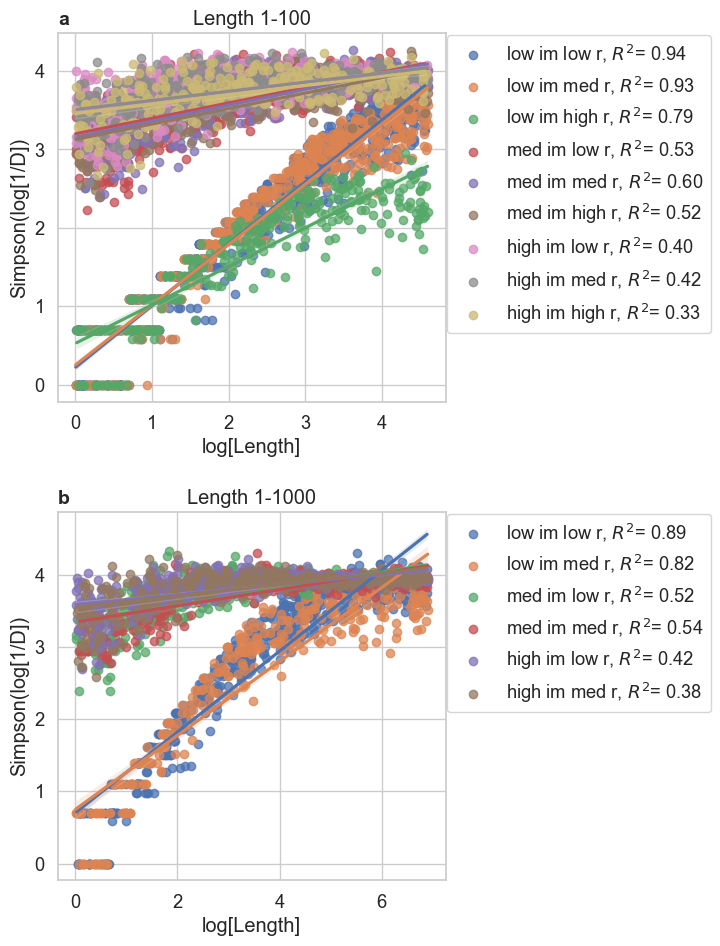

In [3]:
params= {'font.family':'sans-serif',
         'figure.subplot.hspace':0.3, 
         'figure.subplot.wspace':0.3,
         'font.sans-serif':'Arial'
         }
sns.set_theme(style='whitegrid', rc=params, font_scale=1.2)
formula = 'Simpson ~ Length'

fig,axs = plt.subplots(2,1,figsize=(5,11))
plt.subplots_adjust(wspace=1)

folder_location = '/proj/gibbons/kramos/github/IBT-and-the-Gut-Microbiome/IBM/data/small_tests_1-100/'

for file in os.listdir(folder_location): 
    df = pd.read_csv(folder_location + file)
    features = ['Simpson', 'Length'] 
    df[features] = df[features].apply(lambda x: np.log(x))
    x = 'Length'
    y = 'Simpson'
    fitted = ols(formula, data=df).fit()
    r_squared = fitted.rsquared
    info = file.replace('.csv', '').replace('_', ' ') + f', $R^2$= {r_squared:.2f}'
    
    axs[0]=sns.regplot(data=df, x=x, y=y,label = info, scatter_kws={'alpha':0.75}, ax = axs[0])
    axs[0].set_xlabel('log[Length]')
    axs[0].set_ylabel('Simpson(log[1/D])')
    axs[0].set_title('Length 1-100')
    axs[0].legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.1)

folder_location = '/proj/gibbons/kramos/github/IBT-and-the-Gut-Microbiome/IBM/data/large_tests_1-1000/'
for file in os.listdir(folder_location): 
    df = pd.read_csv(folder_location + file)
    features = ['Simpson', 'Length'] 
    df[features] = df[features].apply(lambda x: np.log(x))
    x = 'Length'
    y = 'Simpson'
    fitted = ols(formula, data=df).fit()
    r_squared = fitted.rsquared
    info = file.replace('.csv', '').replace('_', ' ') + f', $R^2$= {r_squared:.2f}'
    
    axs[1]=sns.regplot(data=df, x=x, y=y,label = info, scatter_kws={'alpha':0.75}, ax = axs[1])
    axs[1].set_xlabel('log[Length]')
    axs[1].set_ylabel('Simpson(log[1/D])')
    axs[1].legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.1)
    axs[1].set_title('Length 1-1000')
    
axs[0].set_title('a',loc='left', fontweight='bold', fontsize=14) 
axs[1].set_title('b',loc='left', fontweight='bold', fontsize=14) 


In [4]:
fig.savefig(genpath+'output/static_sim_data.pdf', bbox_inches='tight')
fig.savefig(genpath+'output/static_sim_data.png', bbox_inches='tight')

### Plot the results from my simulated data

In [5]:
human = pd.read_csv(genpath+'IBM/data/final_data/L50-100_Mimr_Mr.csv').dropna()
animal=pd.read_csv(genpath+'IBM/data/final_data/L1-1000_Mimr_Mr.csv').dropna()

In [6]:
animal=animal[np.isfinite(animal)==True]
human=human[np.isfinite(human)==True]

In [7]:
features=['Length', 'Simpson']
human[features]=human[features].apply(lambda x: np.log(x))
animal[features]=animal[features].apply(lambda x: np.log(x))

In [8]:
human.describe()

,sim,ct,Length,TotalAbundance,SpeciesRichness,Simpson,Simpson_e
count,999.000000,999.0,999.000000,999.000000,999.000000,999.000000,999.000000
mean,499.874875,999.0,4.263353,2716.418418,755.164164,3.907257,0.067761
std,288.720589,0.0,0.206542,785.767676,119.956652,0.094290,0.011971
min,0.000000,999.0,3.912733,1607.000000,533.000000,3.587776,0.041951
25%,250.500000,999.0,4.081606,2013.000000,653.000000,3.844724,0.058285
50%,500.000000,999.0,4.263443,2566.000000,744.000000,3.907633,0.066210
75%,749.500000,999.0,4.449486,3382.000000,860.000000,3.970085,0.076178
max,999.000000,999.0,4.604653,4343.000000,1014.000000,4.198213,0.106950


In [9]:
animal.describe()

,sim,ct,Length,TotalAbundance,SpeciesRichness,Simpson,Simpson_e
count,999.000000,999.000000,999.000000,9.990000e+02,999.000000,999.000000,999.000000
mean,499.752753,1005.883884,3.506279,9.864912e+05,991.223223,3.748428,0.232011
std,288.853427,54.583636,1.993901,4.818670e+06,1185.947816,0.307560,0.251023
min,0.000000,999.000000,0.002376,2.500000e+01,17.000000,2.326878,0.010252
25%,250.500000,999.000000,1.816749,1.560000e+02,107.000000,3.644439,0.032224
50%,500.000000,999.000000,3.498079,9.830000e+02,409.000000,3.855022,0.119278
75%,749.500000,999.000000,5.314440,1.640050e+04,1601.000000,3.941052,0.369644
max,999.000000,2581.000000,6.891791,4.502339e+07,4542.000000,4.260261,0.964506


In [10]:
def get_results(feature):
    """Get a single association.
    
    As long as `args` and `df` are assigned this can be used on
    any data set.
    """
    formula = f"{feature} ~ Length"
    fitted = ols(formula, data=df).fit()
    return pd.DataFrame({
        "feature": feature,
        "beta": fitted.params["Length"],
        "t_statistic": fitted.tvalues["Length"],
        "p": fitted.pvalues["Length"],
        "n": fitted.nobs, 
        'rsquared':fitted.rsquared
        }, index=[feature])

args=['Simpson']

In [11]:
df = human
results = map(get_results, track(args))
results = list(results)
human_tests = pd.concat(results)
human_tests["q"] = multipletests(human_tests.p, method="fdr_bh")[1]
human_tests['data']='human'

In [12]:
df = animal
results = map(get_results, track(args))
results = list(results)
animal_tests = pd.concat(results)
animal_tests["q"] = multipletests(animal_tests.p, method="fdr_bh")[1]
animal_tests['data']='animal'

all_tests=pd.concat([animal_tests, human_tests])
all_tests

,feature,beta,t_statistic,p,n,rsquared,q,data
Simpson,Simpson,0.109468,31.806079,8.040298e-154,999.0,0.503641,8.040298e-154,animal
Simpson,Simpson,0.038298,2.658269,7.980082e-03,999.0,0.007038,7.980082e-03,human


In [13]:
all_tests=all_tests.set_index('data')
all_tests

,feature,beta,t_statistic,p,n,rsquared,q
data,,,,,,,
animal,Simpson,0.109468,31.806079,8.040298e-154,999.0,0.503641,8.040298e-154
human,Simpson,0.038298,2.658269,7.980082e-03,999.0,0.007038,7.980082e-03


In [14]:
a_p=all_tests.loc['animal', 'p']
a_p= f'$P$={a_p:.2E}'
a_rsq=all_tests.loc['animal', 'rsquared']
h_p=all_tests.loc['human', 'p']
h_p=f'$P$={h_p:.2E}'
h_rsq=all_tests.loc['human', 'rsquared']

In [15]:
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.exp(-b * x) + c
  

data = animal[['Length', 'Simpson']].sort_values(by='Length')
x,y=data['Length'], data['Simpson']
popt, pcov = curve_fit(func, x, y)


[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 5
    # data points      = 999
    # variables        = 3
    chi-square         = 29.5761533
    reduced chi-square = 0.02969493
    Akaike info crit   = -3510.26659
    Bayesian info crit = -3495.54632
    R-squared          = 0.68670576
[[Variables]]
    a: -1.03730712 +/- 0.02380910 (2.30%) (init = -1.037306)
    b:  0.67082969 +/- 0.03379469 (5.04%) (init = 0.6708246)
    c:  3.96332565 +/- 0.01133138 (0.29%) (init = 3.963327)
[[Correlations]] (unreported correlations are < 0.100)
    C(b, c) = -0.7770
    C(a, b) = -0.3613


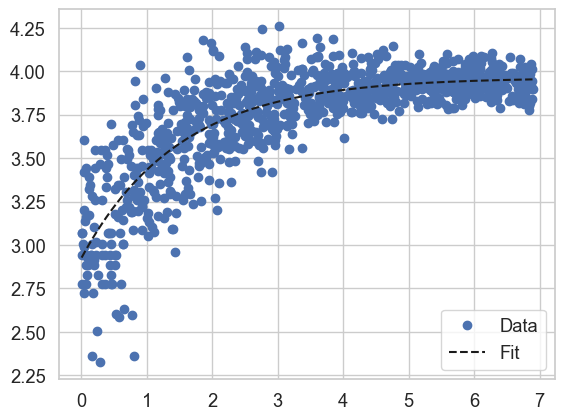

In [16]:
def func_exp(x, a, b, c):
    """Return values from a general exponential function."""
    # return a * np.log(b * x) + c
    return a * np.exp(-b * x) + c


data = animal[['Length', 'Simpson']].sort_values(by='Length')
x_samp,y_samp=data['Length'], data['Simpson']

regressor = lmfit.Model(func_exp)# 1
regressor = lmfit.Model(func)
initial_guess = dict(a=popt[0], b=popt[1], c=popt[2])                      # 2
results = regressor.fit(y_samp, x=x_samp, **initial_guess)
y_fit = results.best_fit

plt.plot(x_samp, y_samp, "o", label="Data")
plt.plot(x_samp, y_fit, "k--", label="Fit")
plt.legend()

print(results.fit_report())
exponential_a_rsq = results.rsquared


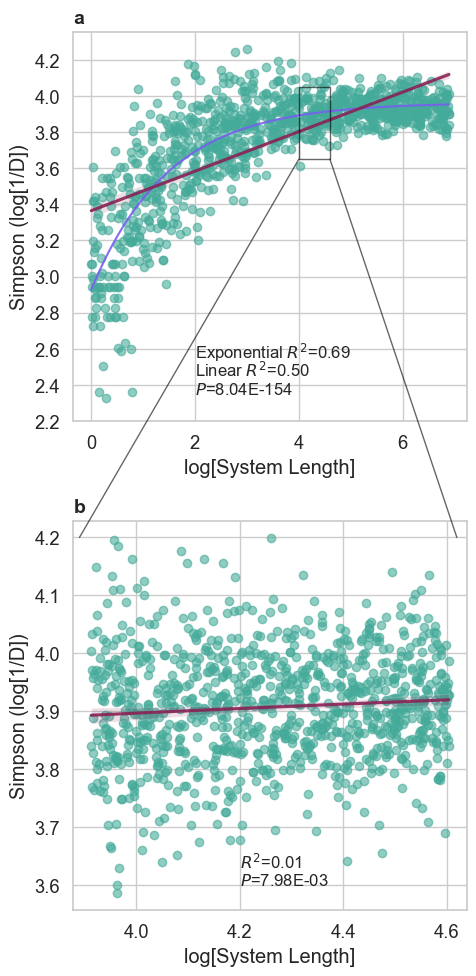

In [17]:
params= {'font.family':'sans-serif',
         'font.sans-serif':'Arial'
         }
sns.set_theme(style='whitegrid', rc=params, font_scale=1.2)
fig, axs = plt.subplots(2,1,figsize=(5,10), tight_layout=True)
fig.subplots_adjust(left=0.5, right=0.6, top=0.5)

x='Length'
y ='Simpson'

axs[0] = sns.regplot(data=animal, ax=axs[0], x=x, y=y, \
            scatter_kws={'alpha':0, 'color':'#44AA99'},\
            line_kws={'color':'#882255', 'alpha':0.9, 'zorder':5})
axs[0].plot(x_samp, y_samp, 'ro', color='#44AA99', alpha=0.6, label="Original Data")
axs[0].plot(x_samp, y_fit, '-', color='#785EF0', alpha=0.9, label="Fitted Curve")
axs[0].set_yticks([2.2, 2.4, 2.6, 2.8,3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2])
axs[0].set(xlabel='log[System Length]', ylabel='Simpson (log[1/D])')
axs[0].set_title('a', loc='left', fontweight='bold', fontsize=14)
axs[0].text(2,2.35, a_p, fontsize=12)
axs[0].text(2,2.45, f'Linear $R^2$={a_rsq:.2f}', fontsize=12)
axs[0].text(2,2.55, f'Exponential $R^2$={exponential_a_rsq:.2f}', fontsize=12)

axs[1] = sns.regplot(data=human, ax=axs[1], x=x, y=y,logx=True,\
            scatter_kws={'alpha':0.6, 'color':'#44AA99'},\
            line_kws={'color':'#882255', 'alpha':0.9})
                   
axs[1].set(xlabel='log[System Length]', ylabel='Simpson (log[1/D])')
axs[1].set_title('b',loc='left', fontweight='bold', fontsize=14) 
axs[1].text(4.2, 3.6, h_p, fontsize=12)
axs[1].text(4.2, 3.63, f'$R^2$={h_rsq:.2f}',fontsize=12)

rectangle=Rectangle((4,3.65),0.6,0.4, color='black', alpha=0.6, fill=False)
axs[0].add_patch(rectangle).set_zorder(5)
con1 = ConnectionPatch(xyA=(4,3.65), xyB=(3.89, 4.2), coordsA='data', coordsB='data',\
                      axesA=axs[0], axesB=axs[1], color='black', linewidth=1, alpha=0.6)
con1.set_zorder(5)
con2 = ConnectionPatch(xyA=(4.6,3.65), xyB=(4.62,4.2), coordsA='data', coordsB='data',\
                      axesA=axs[0], axesB=axs[1], color='black', linewidth=1, alpha=0.6)
con2.set_zorder(5)
fig.add_artist(con1)
fig.add_artist(con2)


In [18]:
fig.savefig(genpath+'/output/sim_data.pdf')
fig.savefig(genpath+'output/sim_data.png')